In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
cifar10_dataset_folder_path = 'cifar-10-batches-py'
class DLProgress(tqdm):
    last_block = 0
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
                    'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                    'cifar-10-python.tar.gz',pbar.hook)
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()     

In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_training.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])



Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


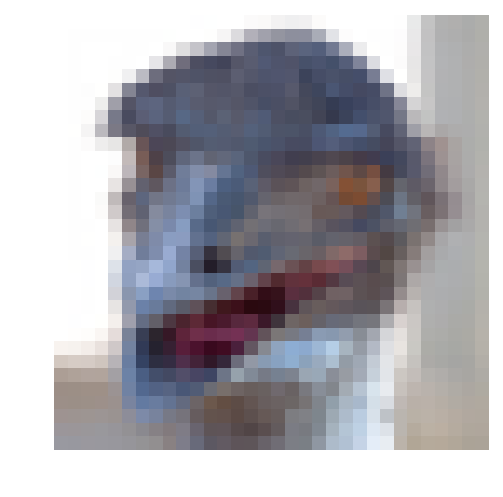

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 5
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [37]:
import numpy as np
def normalize(x):
    x = np.array(x)
    x_max = np.max(x)
    x_min = np.min(x)
    output = (x-x_min)/(x_max-x_min)
    return output

In [38]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(range(10))
def one_hot_encode(x):
    return lb.transform(x)

In [36]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [24]:
###

In [26]:
# Remove previous weights, bias, inputs, etc..
import tensorflow as tf
tf.reset_default_graph()
# Inputs
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 10), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [27]:
def conv_net(x, keep_prob):

    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], mean=0, stddev=0.08))

    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))

    conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))

    conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))


    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')

    conv1 = tf.nn.relu(conv1)

    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    conv1_bn = tf.layers.batch_normalization(conv1_pool)


    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')

    conv2 = tf.nn.relu(conv2)

    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    

    conv2_bn = tf.layers.batch_normalization(conv2_pool)

  

    # 5, 6

    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')

    conv3 = tf.nn.relu(conv3)

    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  

    conv3_bn = tf.layers.batch_normalization(conv3_pool)

    

    # 7, 8

    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')

    conv4 = tf.nn.relu(conv4)

    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    conv4_bn = tf.layers.batch_normalization(conv4_pool)

    

    # 9

    flat = tf.contrib.layers.flatten(conv4_bn)  



    # 10

    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)

    full1 = tf.nn.dropout(full1, keep_prob)

    full1 = tf.layers.batch_normalization(full1)

    

    # 11

    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)

    full2 = tf.nn.dropout(full2, keep_prob)

    full2 = tf.layers.batch_normalization(full2)

    

    # 12

    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)

    full3 = tf.nn.dropout(full3, keep_prob)

    full3 = tf.layers.batch_normalization(full3)    

    

    # 13

    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)

    full4 = tf.nn.dropout(full4, keep_prob)

    full4 = tf.layers.batch_normalization(full4)        

    

    # 14

    out = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=10, activation_fn=None)

    return out

In [29]:
#Hyper parameter
epochs = 10
batch_size = 128
keep_probability = 0.7
learning_rate = 0.001

In [30]:
logits = conv_net(x, keep_prob)
# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [34]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, 
                feed_dict={
                    x: feature_batch,
                    y: label_batch,
                    keep_prob: keep_probability
                })

In [33]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost,
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [39]:
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5 h4q4g6
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)

Epoch  1, CIFAR-10 Batch 1:  Loss:     2.1527 Validation Accuracy: 0.226400
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.7834 Validation Accuracy: 0.318600
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.6033 Validation Accuracy: 0.326800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5667 Validation Accuracy: 0.402000
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.4164 Validation Accuracy: 0.418400
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3811 Validation Accuracy: 0.496800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.1477 Validation Accuracy: 0.461800
Epoch  2, CIFAR-10 Batch 3:  Loss:     0.9912 Validation Accuracy: 0.524800
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.0475 Validation Accuracy: 0.576400
Epoch  2, CIFAR-10 Batch 5:  Loss:     0.8776 Validation Accuracy: 0.592800
Epoch  3, CIFAR-10 Batch 1:  Loss:     0.7739 Validation Accuracy: 0.631200
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.6153 Validation Accuracy: 0.657600
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.3757 Validation Accuracy: 0.660600
Epoch  3, CI